In [1]:
"""
Get percentiles of variable in netCDF files.

"""
import glob
import os
import pdb
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray

sns.set_theme()

def assignCoords(ds: xarray.Dataset):
    """
    Assign member number, forecast hour,
    initialiation time, and valid time to xarray Dataset.
    - Read member number from component of file path
    - Get forecast hour from global attribute (.attrs["forecastHour"])
    - init time comes from global attribute
    - valid time derived from init time and forecast hour.
    """

    ds = ds.squeeze(dim="time")
    # get member number from original name of file, which is
    # held in Dataset.encoding["source"].
    filename = Path(ds.encoding["source"])
    # grab part that starts with "mem"
    mem = [p for p in filename.parts if p.startswith("mem")]
    # strip off the "mem_" part and keep the reset
    mem = mem[0].lstrip("mem_")
    # convert to integer
    mem = int(mem)

    # read forecastHour from global attribute
    forecastHour = ds.attrs["forecastHour"]
    forecastHour = float(forecastHour)

    # read initializationTime from global attribute
    initializationTime = ds.attrs["initializationTime"]
    initializationTime = pd.to_datetime(initializationTime, format="%Y%m%d%H")

    #  valid_time = initializationTime + forecastHour
    valid_time = initializationTime + pd.to_timedelta(forecastHour, unit="hour")

    # I brought these assignments down here together to see if it is faster.
    # assign to coordinate
    ds = ds.assign_coords(mem=mem, initializationTime=initializationTime)
    # thought assign_coords would add dim to data_vars but it didn't
    ds = ds.expand_dims(dim=["mem", "initializationTime"])
    # no square brackets around initializationTime so it doesn't become a coordinate.
    # ds = ds.assign(initializationTime=initializationTime)
    ds = ds.assign(
        forecastHour=[forecastHour],
        valid_time=valid_time,
    )
    return ds


def flatp(da, q):
    return xarray.DataArray(np.percentile(da, q), coords={"percentile": q})


percentiles = [
    97,
    98,
    99,
    99.5,
    99.75,
    99.85,
    99.875,
    99.9,
    99.925,
    99.95,
    99.975,
    99.99,
    99.9925,
    99.995,
    99.9975,
]

In [2]:
#  mask
maskfile = "~ahijevyc/HWT_2024.conus.nc"
mask = xarray.open_dataarray(maskfile)

In [3]:
files = glob.glob("/glade/campaign/mmm/parc/schwartz/HWT202?/fv3/202?0???00/post/mem_1/inter*f024.nc")
print(f"read {len(files)} files")
ds0 = xarray.open_mfdataset(
    files,
    preprocess=assignCoords,
    drop_variables=["total_precip_hrly"],
    combine_attrs="drop",
    compat="override",
    coords="minimal",
    parallel=True,
)
ds0

read 80 files


<xarray.Dataset> Size: 48GB
Dimensions:             (mem: 1, initializationTime: 80, lat: 1059, lon: 1799,
                         forecastHour: 1)
Coordinates:
  * mem                 (mem) int64 8B 1
  * initializationTime  (initializationTime) datetime64[ns] 640B 2023-04-24 ....
  * forecastHour        (forecastHour) float64 8B 24.0
Dimensions without coordinates: lat, lon
Data variables: (12/79)
    latitude            (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    longitude           (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    REFC                (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    CAPEsfc             (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    UGRD925             (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    UGRD850             (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    ...                  ...
    PRATEsfc            (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    PRATEsfc_accum      (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    UGRD10m             (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    VGRD10m             (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    SPFH2m              (mem, initializationTime, lat, lon) float32 610MB dask.array<chunksize=(1, 1, 1059, 1799), meta=np.ndarray>
    valid_time          (initializationTime) datetime64[ns] 640B 2023-04-25 ....

In [50]:
v = (
    [v for v in ds0.variables if "UPHL" in v]
    + [v for v in ds0.variables if "REF" in v]
    + [v for v in ds0.variables if "VV" in v]
    + ["MAXWIND10m"]
)
print(v)
ds = ds0[v].where(mask).stack(z=("lon", "lat")).dropna(dim="z")
ds

['MXUPHL2_5km_max', 'MNUPHL2_5km_min', 'MXUPHL0_3km_max', 'MNUPHL0_3km_min', 'MXUPHL0_1km_max', 'MNUPHL0_1km_min', 'REFC', 'REFD1km', 'MAXREF_1km_max', 'MAXREFC_max', 'MAXUVV_max', 'MAXDVV_min', 'MAXWIND10m']


<xarray.Dataset> Size: 4GB
Dimensions:             (mem: 1, initializationTime: 80, z: 905466)
Coordinates:
  * mem                 (mem) int64 8B 1
  * initializationTime  (initializationTime) datetime64[ns] 640B 2023-04-24 ....
  * z                   (z) object 7MB MultiIndex
  * lon                 (z) int64 7MB 148 148 149 149 ... 1693 1693 1693 1694
  * lat                 (z) int64 7MB 704 705 702 703 704 ... 895 896 897 896
Data variables: (12/13)
    MXUPHL2_5km_max     (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MNUPHL2_5km_min     (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MXUPHL0_3km_max     (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MNUPHL0_3km_min     (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MXUPHL0_1km_max     (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MNUPHL0_1km_min     (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    ...                  ...
    REFD1km             (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MAXREF_1km_max      (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MAXREFC_max         (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MAXUVV_max          (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MAXDVV_min          (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>
    MAXWIND10m          (mem, initializationTime, z) float32 290MB dask.array<chunksize=(1, 1, 905466), meta=np.ndarray>

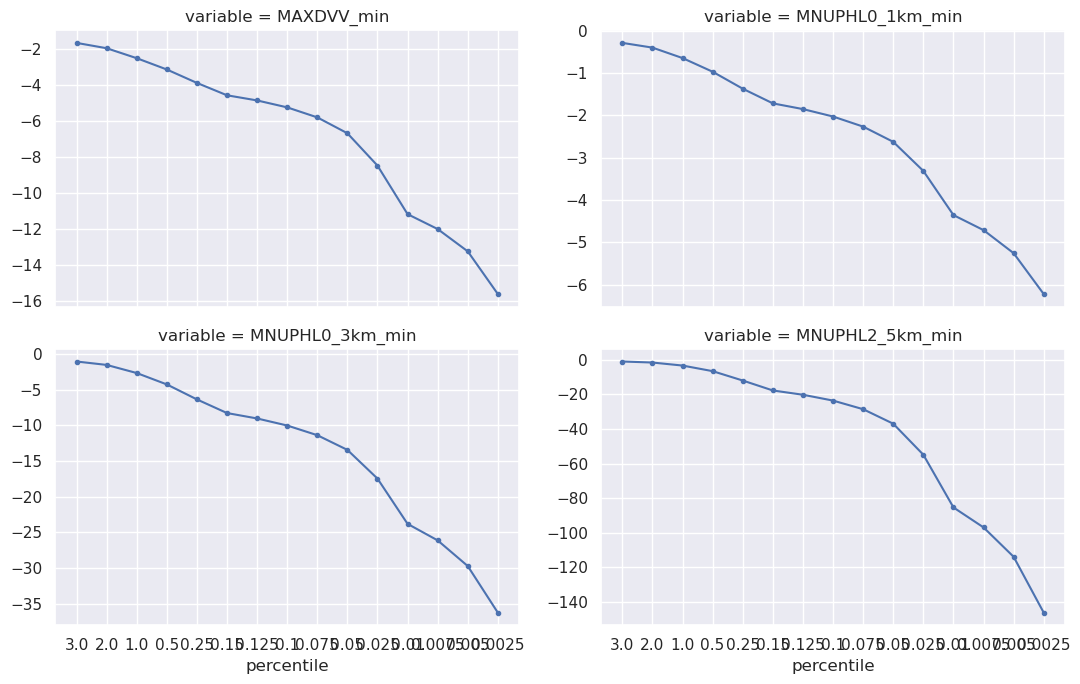

In [61]:
vars = [v for v in ds.variables if v.startswith("MN")] + ["MAXDVV_min"]
pct = ds[vars].to_dataarray().groupby("variable").apply(flatp, q=[100-p for p in percentiles])
pct.coords["percentile"] = pct.coords["percentile"].round(decimals=4).astype(str)
ofile = "pct.MN.nc"
pct.to_netcdf(ofile)
fg = pct.plot.line(x="percentile", col="variable", marker=".", col_wrap=2, sharey=False, figsize=(11,7))
#fg.set_ticks(max_xticks=8)

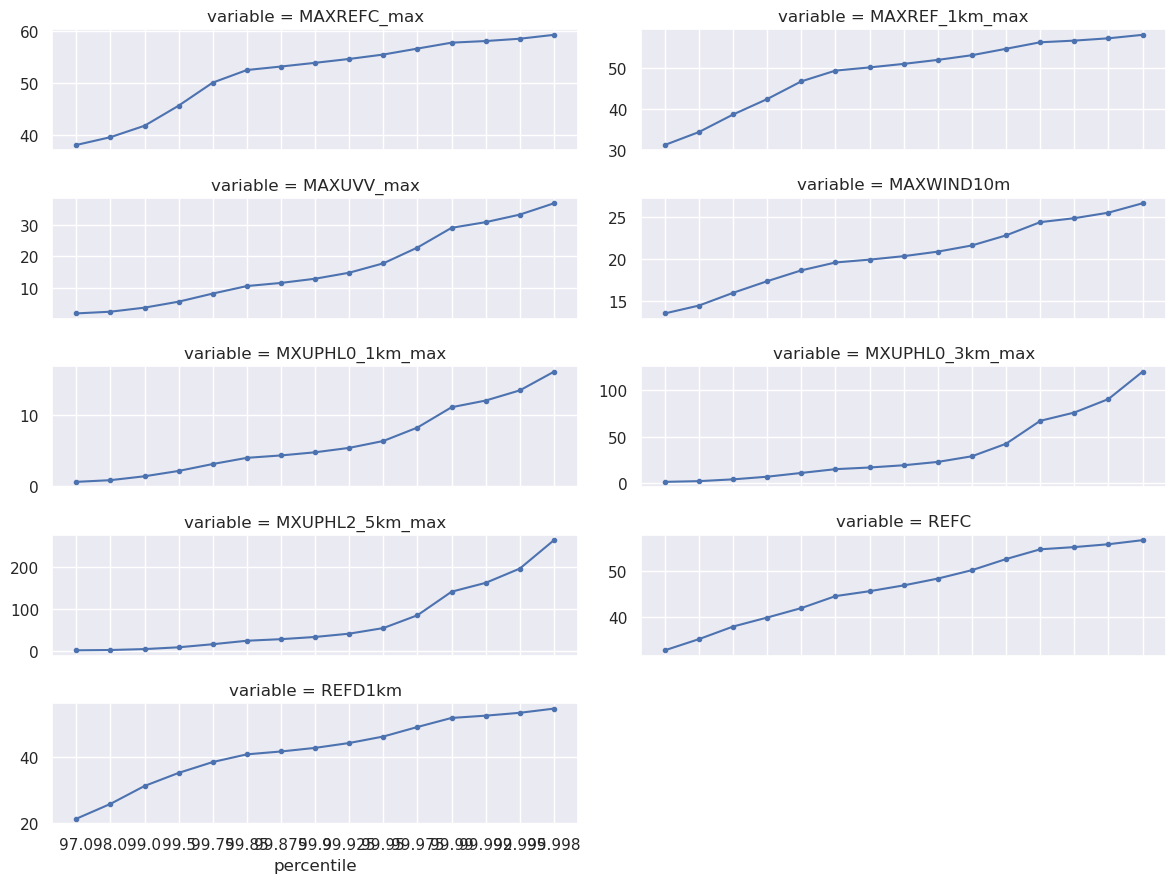

In [68]:
pct = ds.drop_vars(vars).to_dataarray().groupby("variable").apply(flatp, q=percentiles)
pct.coords["percentile"] = pct.coords["percentile"].round(decimals=3).astype(str)
ofile = "pct.nc"
pct.to_netcdf(ofile)
fg = pct.plot.line(x="percentile", col="variable", marker=".", col_wrap=2, sharey=False, figsize=(12,9))

In [67]:
dir(fg)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adjust_fig_for_guide',
 '_bottom_axes',
 '_cmap_extend',
 '_col_var',
 '_col_wrap',
 '_finalize_grid',
 '_finalized',
 '_get_largest_lims',
 '_hue_var',
 '_is_protocol',
 '_left_axes',
 '_mappables',
 '_ncol',
 '_nrow',
 '_row_var',
 '_set_labels',
 '_set_lims',
 '_single_group',
 '_x_var',
 '_y_var',
 'add_colorbar',
 'add_legend',
 'add_quiverkey',
 'axes',
 'axs',
 'cbar',
 'col_labels',
 'col_names',
 'data',
 'fig',
 'figlegend',
 'map',
 'map_dataarray',
 'map_dataarray_line',
 'map_dataset',
 'map_plot1d